In [1]:
import pandas as pd
!pip install shapely

DEPRECATION: pandas 0.23.4 has a non-standard dependency specifier pytz>=2011k. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pandas or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: unyt 2.8.0 has a non-standard dependency specifier numpy>="1.13.0". pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of unyt or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
%run ROUTINES/gauss_asym.py

In [3]:
%matplotlib widget

## Load fit info

In [4]:
#df_fits = pd.read_csv('fit_info/fit_sobrevivientes_rho_arm2.csv')

id_halo='418336'
df_fits = pd.read_csv(f'FIT_INFO/fit_params_rho_arm1_all_points_HALO{id_halo}_.csv')
df_fits['x'] = df_fits.apply(lambda row: convert_from_listAsAString_to_listOfFloats(row.x), axis = 1)
df_fits['y'] = df_fits.apply(lambda row: convert_from_listAsAString_to_listOfFloats(row.y), axis = 1)

In [5]:
df_fits.tail(3)

,amplitude,center,delta,fractured,gamma,id_tracing,sigma,stderr_amplitude,stderr_center,stderr_gamma,stderr_sigma,x,x_tracing,y,y_tracing
16,0.000045,4.344097,0.05,False,-6.754147,15.0,0.654268,0.000006,0.075906,7.683099,0.059111,"[3.0203291066910594, 3.1079254540232917, 3.143...",1.115260,"[1.018004186837198e-05, 1.6040179036575887e-05...",-3.432224
17,0.000069,4.926604,0.05,False,-1.917496,16.0,0.653699,0.000008,0.099862,1.935412,0.142708,"[3.3264017401191968, 3.413535574633174, 3.5441...",0.180195,"[2.3827927047437873e-06, 6.769767154572749e-06...",-4.289367
18,0.000066,4.951281,0.05,False,-4.564456,17.0,0.712112,0.000006,0.036136,2.116323,0.098251,"[3.794393851170632, 3.872662435912499, 3.98669...",-0.560065,"[2.2897908523651877e-05, 2.0053903331272268e-0...",-4.717938


In [6]:
params = df_fits.iloc[0] # Para investigar los resultado del fit de un punto, llamamos su fila en el DataFrame

In [7]:
params

amplitude                                                 6.78097e-05
center                                                        3.06563
delta                                                            0.05
fractured                                                       False
gamma                                                        -7.05363
id_tracing                                                          0
sigma                                                         1.74956
stderr_amplitude                                          7.57502e-06
stderr_center                                               0.0515172
stderr_gamma                                                  2.81469
stderr_sigma                                                 0.285681
x                   [0.930161058695907, 1.1501515575441807, 1.2251...
x_tracing                                                     -1.9237
y                   [8.431093497257162e-06, 1.9053676360018433e-05...
y_tracing           

In [8]:
#import numpy as np

# Convertir las columnas 'x' y 'y' de cadenas a arrays numéricos
#params['x'] = np.array(params['x'].split('\\n'), dtype=float)
#params['y'] = np.array(params['y'].split('\\n'), dtype=float)

# Verificar los resultados
#print("X values:", params['x'])
#print("Y values:", params['y'])


In [9]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False


In [10]:
from shapely.geometry import LineString

def find_widths_of_skewed_gaussian_dani(params, dx=0.001):
    # Evaluar el modelo ajustado
    fitted_model = eval_fitted_model_with_given_params(params, dx=dx)
    x_eval = fitted_model['x_eval']
    y_eval = fitted_model['y_eval']

    # Encuentra el máximo
    x_max, y_max = find_maximum(x_eval, y_eval)

    # Generar la línea horizontal en y = y_max / 2
    xs_line = np.arange(np.min(x_eval), np.max(x_eval), 0.01)
    ys_line = np.full(len(xs_line), 0.5 * y_max)

    # Crear LineString para las dos líneas
    first_line = LineString(np.column_stack((x_eval, y_eval)))
    second_line = LineString(np.column_stack((xs_line, ys_line)))
    intersection = first_line.intersection(second_line)

    points_intercept = []

    # Si la intersección es un solo punto
    if intersection.geom_type == 'Point':
        points_intercept = [(intersection.x, intersection.y)]
    # Si la intersección es una colección de puntos
    elif hasattr(intersection, 'geoms'):
        points_intercept = [(point.x, point.y) for point in intersection.geoms]
    # Si no hay intersección
    elif intersection.is_empty:
        return {'x_max': x_max, 'y_max': y_max, 'w1': np.nan, 'w2': np.nan}

    # Asegurarse de que hay suficientes puntos de intersección
    if len(points_intercept) >= 2:
        w1 = x_max - points_intercept[1][0]
        w2 = points_intercept[0][0] - x_max
    else:
        w1, w2 = np.nan, np.nan  # Si no hay suficientes intersecciones

    return {'x_max': x_max, 'y_max': y_max, 'w1': w1, 'w2': w2}

def plot_fit_and_widths_dani(params, ax, dx=0.001):
    width_info = find_widths_of_skewed_gaussian_dani(params, dx=dx)

    dict_eval = eval_fitted_model_with_given_params(params, dx=dx)
    x_eval = dict_eval['x_eval']
    y_eval = dict_eval['y_eval']

    # Plotea la función ajustada
    ax.plot(x_eval, y_eval, lw=2.5, label='Fitted Function')

    # Máximos y anchos
    ax.axvline(x=width_info['x_max'], color='red', lw=1.5, label='x_max = {:.3f}'.format(width_info['x_max']))
    ax.axhline(y=width_info['y_max'], ls='--', color='k', label='y_max = {:.2e}'.format(width_info['y_max']))
    ax.axhline(y=0.5 * width_info['y_max'], color='green', lw=1.5, label='y_max / 2 = {:.2e}'.format(0.5 * width_info['y_max']))

    # Líneas verticales para w1 y w2
    ax.axvline(x=np.abs(width_info['x_max'] - width_info['w1']), color='magenta', lw=1.5, ls='--', label='w1 = {:.3f}'.format(width_info['w1']))
    ax.axvline(x=np.abs(width_info['x_max'] + width_info['w2']), color='purple', lw=1.5, ls='--', label='w2 = {:.3f}'.format(width_info['w2']))

    # Ajustar etiquetas de los ticks
    xt = ax.get_xticks()
    tick1 = '{:.2f}'.format(np.abs(width_info['x_max'] - width_info['w1']))
    tick2 = '{:.2f}'.format(np.abs(width_info['x_max'] + width_info['w2']))
    xt = np.append(xt, [float(tick1), float(tick2)])

    ax.set_xticks(xt)
    ax.set_xticklabels(xt)

    ax.grid(alpha=0.5, lw=1, ls='--')
    ax.legend(loc='upper left')



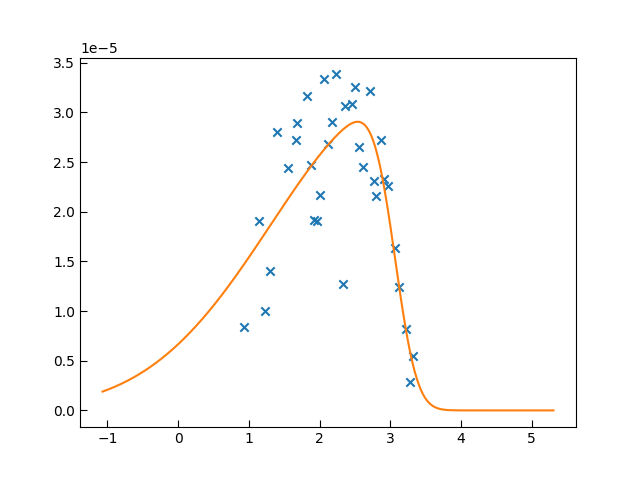

In [11]:
%matplotlib widget
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False

# Graficamos el fit y los puntos con los que se hizo el fit
fig, ax = plt.subplots()
ax.scatter(params.x, params.y, color = 'C0', marker = 'x') # Envoltorio
model_eval = eval_fitted_model_with_given_params(params, dx = 0.01) # Funcion en gauss_asym.py
x_eval = model_eval['x_eval']
y_eval = model_eval['y_eval']
ax.plot(x_eval, y_eval,color = 'C1'); # Fit

## Calculate width of a fit

In [12]:
%run ROUTINES/gauss_asym.py

In [13]:
dx = 0.001 # Discretizacion para mapear la gaussiana

In [14]:
width_info = find_widths_of_skewed_gaussian_dani(params, dx = dx) # Funcion en gauss_asym.py

In [15]:
width_info # Retorna la ubicacion del maximo (x_max, y_max) y el ancho a la izquierda (w1) y a la derecha (w2)

{'x_max': 2.53916105869551,
 'y_max': 2.9056251157760636e-05,
 'w1': 1.6240821469401436,
 'w2': 0.5452546283253406}

In [16]:
#fig, ax = plt.subplots(figsize=(10,5))
#plot_fit_and_widths(params, ax, dx = dx) # Funcion en gauss_asym.py

In [17]:
# Podemos aplicar find_widths_of_skewed_gaussian() a toda la tabla con la informacion de los parametros 

df_fits['width_info'] = df_fits.apply(lambda row: find_widths_of_skewed_gaussian_dani(row), axis = 1)
df_fits['x_max'] = df_fits.apply(lambda row: row.width_info['x_max'], axis = 1)
df_fits['y_max'] = df_fits.apply(lambda row: row.width_info['y_max'], axis = 1)
df_fits['w1'] = df_fits.apply(lambda row: row.width_info['w1'], axis = 1)
df_fits['w2'] = df_fits.apply(lambda row: row.width_info['w2'], axis = 1)

In [18]:


df_fits.head(10)

,amplitude,center,delta,fractured,gamma,id_tracing,sigma,stderr_amplitude,stderr_center,stderr_gamma,stderr_sigma,x,x_tracing,y,y_tracing,width_info,x_max,y_max,w1,w2
0,0.000068,3.065634,0.05,False,-7.053630,0.0,1.749561,0.000008,0.051517,2.814693,0.285681,"[0.930161058695907, 1.1501515575441807, 1.2251...",-1.923701,"[8.431093497257162e-06, 1.9053676360018433e-05...",1.243101,"{'x_max': 2.53916105869551, 'y_max': 2.9056251...",2.539161,0.000029,1.624082,0.545255
1,0.000055,3.024764,0.05,False,-16.454760,1.0,1.511794,0.000010,0.029237,8.409464,0.359080,"[1.352420271861308, 1.785603231598143, 1.84240...",-1.845779,"[1.2892553254869941e-05, 1.6770316187792396e-0...",1.866477,"{'x_max': 2.7754202718613112, 'y_max': 2.84117...",2.775420,0.000028,1.552266,0.251277
2,0.000052,3.075053,0.05,False,-19.590814,2.0,1.404767,0.000006,0.020546,9.836535,0.224496,"[1.4482446353081517, 1.717248282027308, 1.7936...",-1.222403,"[1.0478769125488477e-05, 1.3645837889067874e-0...",2.411932,"{'x_max': 2.8722446353081548, 'y_max': 2.93184...",2.872245,0.000029,1.466337,0.203949
3,0.000041,2.968287,0.05,False,-14.223399,3.0,1.155108,0.000004,0.021170,6.682713,0.151802,"[1.2271548653340463, 1.62433466694541, 1.69840...",-0.326299,"[7.1152624427028665e-06, 1.2939142705295395e-0...",2.645698,"{'x_max': 2.7551548653340494, 'y_max': 2.76845...",2.755155,0.000028,1.167712,0.215285
4,0.000055,2.564958,0.05,False,0.041090,4.0,0.840902,0.000035,1371.885708,2050.019596,51.304301,"[1.2344969607324965, 1.7064588518468178, 1.811...",0.569805,"[6.5763466802385964e-06, 1.708931108604707e-05...",2.489854,"{'x_max': 2.5924969607324995, 'y_max': 2.63270...",2.592497,0.000026,0.989551,0.989560
5,0.000041,3.118374,0.05,False,-4.914124,5.0,0.948887,0.000005,0.115127,4.276253,0.085126,"[1.61319627681, 1.7131624069583615, 1.84939299...",1.621753,"[9.775643875782044e-06, 1.26780181733194e-05, ...",2.256088,"{'x_max': 2.763196276810003, 'y_max': 3.133017...",2.763196,0.000031,0.842588,0.378973
6,0.000041,3.118374,0.05,False,-4.914124,5.0,0.948887,0.000005,0.115127,4.276253,0.085126,"[1.61319627681, 1.7131624069583615, 1.84939299...",1.621753,"[9.775643875782044e-06, 1.26780181733194e-05, ...",2.256088,"{'x_max': 2.763196276810003, 'y_max': 3.133017...",2.763196,0.000031,0.842588,0.378973
7,0.000058,3.123517,0.05,False,-7.757767,6.0,1.317065,0.000004,0.046908,3.942511,0.104690,"[1.0664025388277603, 1.2476734431656324, 1.268...",2.245130,"[1.1080322456557369e-05, 1.7128725486020925e-0...",1.632711,"{'x_max': 2.7514025388277634, 'y_max': 3.35328...",2.751403,0.000034,1.238109,0.383344
8,0.000058,1.786908,0.05,False,4.715689,7.0,1.500044,0.000008,0.066392,2.664894,0.332100,"[1.6416074684001694, 1.6936437084365796, 1.834...",2.556818,"[9.335432745877142e-06, 1.3393178973385508e-05...",0.814529,"{'x_max': 2.360607468400172, 'y_max': 2.782742...",2.360607,0.000028,0.615007,1.326787
9,0.000067,1.830593,0.05,False,1.928790,8.0,1.394173,0.000007,0.243776,1.658938,0.458043,"[1.3315129282609672, 1.4812994506835715, 1.725...",2.829545,"[6.355240525133809e-06, 1.4961756686899603e-05...",0.269075,"{'x_max': 2.5745129282609702, 'y_max': 2.83821...",2.574513,0.000028,0.977888,1.224569


In [19]:
df_fits

,amplitude,center,delta,fractured,gamma,id_tracing,sigma,stderr_amplitude,stderr_center,stderr_gamma,stderr_sigma,x,x_tracing,y,y_tracing,width_info,x_max,y_max,w1,w2
0,0.000068,3.065634,0.05,False,-7.053630,0.0,1.749561,0.000008,0.051517,2.814693,0.285681,"[0.930161058695907, 1.1501515575441807, 1.2251...",-1.923701,"[8.431093497257162e-06, 1.9053676360018433e-05...",1.243101,"{'x_max': 2.53916105869551, 'y_max': 2.9056251...",2.539161,0.000029,1.624082,0.545255
1,0.000055,3.024764,0.05,False,-16.454760,1.0,1.511794,0.000010,0.029237,8.409464,0.359080,"[1.352420271861308, 1.785603231598143, 1.84240...",-1.845779,"[1.2892553254869941e-05, 1.6770316187792396e-0...",1.866477,"{'x_max': 2.7754202718613112, 'y_max': 2.84117...",2.775420,0.000028,1.552266,0.251277
2,0.000052,3.075053,0.05,False,-19.590814,2.0,1.404767,0.000006,0.020546,9.836535,0.224496,"[1.4482446353081517, 1.717248282027308, 1.7936...",-1.222403,"[1.0478769125488477e-05, 1.3645837889067874e-0...",2.411932,"{'x_max': 2.8722446353081548, 'y_max': 2.93184...",2.872245,0.000029,1.466337,0.203949
3,0.000041,2.968287,0.05,False,-14.223399,3.0,1.155108,0.000004,0.021170,6.682713,0.151802,"[1.2271548653340463, 1.62433466694541, 1.69840...",-0.326299,"[7.1152624427028665e-06, 1.2939142705295395e-0...",2.645698,"{'x_max': 2.7551548653340494, 'y_max': 2.76845...",2.755155,0.000028,1.167712,0.215285
4,0.000055,2.564958,0.05,False,0.041090,4.0,0.840902,0.000035,1371.885708,2050.019596,51.304301,"[1.2344969607324965, 1.7064588518468178, 1.811...",0.569805,"[6.5763466802385964e-06, 1.708931108604707e-05...",2.489854,"{'x_max': 2.5924969607324995, 'y_max': 2.63270...",2.592497,0.000026,0.989551,0.989560
5,0.000041,3.118374,0.05,False,-4.914124,5.0,0.948887,0.000005,0.115127,4.276253,0.085126,"[1.61319627681, 1.7131624069583615, 1.84939299...",1.621753,"[9.775643875782044e-06, 1.26780181733194e-05, ...",2.256088,"{'x_max': 2.763196276810003, 'y_max': 3.133017...",2.763196,0.000031,0.842588,0.378973
6,0.000041,3.118374,0.05,False,-4.914124,5.0,0.948887,0.000005,0.115127,4.276253,0.085126,"[1.61319627681, 1.7131624069583615, 1.84939299...",1.621753,"[9.775643875782044e-06, 1.26780181733194e-05, ...",2.256088,"{'x_max': 2.763196276810003, 'y_max': 3.133017...",2.763196,0.000031,0.842588,0.378973
7,0.000058,3.123517,0.05,False,-7.757767,6.0,1.317065,0.000004,0.046908,3.942511,0.104690,"[1.0664025388277603, 1.2476734431656324, 1.268...",2.245130,"[1.1080322456557369e-05, 1.7128725486020925e-0...",1.632711,"{'x_max': 2.7514025388277634, 'y_max': 3.35328...",2.751403,0.000034,1.238109,0.383344
8,0.000058,1.786908,0.05,False,4.715689,7.0,1.500044,0.000008,0.066392,2.664894,0.332100,"[1.6416074684001694, 1.6936437084365796, 1.834...",2.556818,"[9.335432745877142e-06, 1.3393178973385508e-05...",0.814529,"{'x_max': 2.360607468400172, 'y_max': 2.782742...",2.360607,0.000028,0.615007,1.326787
9,0.000067,1.830593,0.05,False,1.928790,8.0,1.394173,0.000007,0.243776,1.658938,0.458043,"[1.3315129282609672, 1.4812994506835715, 1.725...",2.829545,"[6.355240525133809e-06, 1.4961756686899603e-05...",0.269075,"{'x_max': 2.5745129282609702, 'y_max': 2.83821...",2.574513,0.000028,0.977888,1.224569


## Results

In [20]:
df_tracing_arm1 = pd.read_csv(f'DATA/processed/TracingPoints/arm_tracing_{id_halo}_arm1_rho_dani.csv')
df_tracing_arm1['arm'] = [1]*len(df_tracing_arm1)
df_tracing_arm1['id'] = np.arange(0,len(df_tracing_arm1),1)

df_tracing_arm2 = pd.read_csv(f'DATA/processed/TracingPoints/arm_tracing_{id_halo}_arm2_rho_dani.csv')
df_tracing_arm2['arm'] = [2]*len(df_tracing_arm2)
df_tracing_arm2['id'] = np.arange(0,len(df_tracing_arm2),1)

df_arms = pd.concat([df_tracing_arm1,df_tracing_arm2], axis = 0).reset_index(drop=True)

In [21]:
df_arms.head(3)

,x,y,arm,id
0,-1.923701,1.243101,1,0
1,-1.845779,1.866477,1,1
2,-1.222403,2.411932,1,2


In [22]:
# Aplicar la función en las columnas 'x' y 'y'
dfs = []
for i, arm in enumerate(['arm1', 'arm2']):
    df_fits = pd.read_csv(f'FIT_INFO/fit_params_rho_{arm}_all_points_HALO{id_halo}_.csv')
    
    # Aplicar la limpieza y conversión en las columnas 'x' y 'y'
    df_fits['x'] = df_fits.apply(lambda row: convert_from_listAsAString_to_listOfFloats(row.x), axis=1)
    df_fits['y'] = df_fits.apply(lambda row: convert_from_listAsAString_to_listOfFloats(row.y), axis=1)
    print(i,arm)
    
    # Añadir la columna 'arm'
    df_fits['arm'] = [i+1] * len(df_fits)
    
    dfs.append(df_fits)



0 arm1
1 arm2


In [23]:
df_fits = pd.concat(dfs, axis = 0).reset_index(drop=True)
df_fits['r_tracing'] = np.sqrt(df_fits['x_tracing']**2 + df_fits['y_tracing']**2)
df_fits['width_info'] = df_fits.apply(lambda row: find_widths_of_skewed_gaussian_dani(row), axis = 1)
df_fits['x_max'] = df_fits.apply(lambda row: row.width_info['x_max'], axis = 1)
df_fits['y_max'] = df_fits.apply(lambda row: row.width_info['y_max'], axis = 1)
df_fits['w1'] = df_fits.apply(lambda row: row.width_info['w1'], axis = 1)
df_fits['w2'] = df_fits.apply(lambda row: row.width_info['w2'], axis = 1)

In [24]:
 df_fits['arm'].nunique()

2

In [25]:
fits_arm1 = df_fits[df_fits.arm == 1]
fits_arm2 = df_fits[df_fits.arm == 2]

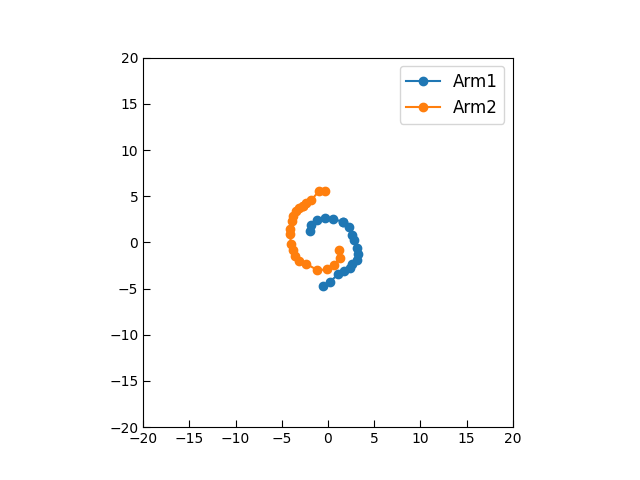

In [26]:
%matplotlib widget
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False

fig, ax = plt.subplots()
ax.plot(fits_arm1.x_tracing, fits_arm1.y_tracing, marker = 'o', label = 'Arm1')
ax.plot(fits_arm2.x_tracing, fits_arm2.y_tracing, marker = 'o', label = 'Arm2')
ax.set_xlim(-20,20)
ax.set_ylim(-20,20)
ax.legend()
ax.set_aspect('equal')

In [27]:
def calc_euclidean(x1,y1,x2,y2):
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

In [28]:
dist_previous = []
for i in range(len(df_tracing_arm2)):
    if i == 0:
        x1 = 0
        y1 = 0
        
        x2 = df_tracing_arm2.iloc[i].x
        y2 = df_tracing_arm2.iloc[i].y
        dist_previous.append(calc_euclidean(x1,y1,x2,y2))
        
    else:
        x1 = df_tracing_arm2.iloc[i-1].x
        y1 = df_tracing_arm2.iloc[i-1].y
        
        x2 = df_tracing_arm2.iloc[i].x
        y2 = df_tracing_arm2.iloc[i].y
        
        dist_previous.append(calc_euclidean(x1,y1,x2,y2))

In [29]:
df_tracing_arm2['dist_previous'] = dist_previous
df_tracing_arm2['arm_length'] = df_tracing_arm2.dist_previous.cumsum()



In [30]:
df_tracing_arm2.head(3)

,x,y,arm,id,dist_previous,arm_length
0,-0.326299,5.606737,2,0,5.616224,5.616224
1,-0.949675,5.567776,2,1,0.624593,6.240817
2,-1.378247,5.100244,2,2,0.634240,6.875057


In [31]:
def assign_length(id_tracing, df_tracing):
    length = df_tracing[df_tracing.id == id_tracing].arm_length.values[0]
    return length

In [32]:
fits_arm2['arm_length'] = fits_arm2.apply(lambda row: assign_length(row.id_tracing, df_tracing_arm2), axis = 1)

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [33]:
fits_arm2.to_csv(f'DATA/results/Halo_{id_halo}_Arm2_widths_Oct10.csv')

In [34]:
fits_arm2.head(3)

,amplitude,center,delta,fractured,gamma,id_tracing,sigma,stderr_amplitude,stderr_center,stderr_gamma,...,y,y_tracing,arm,r_tracing,width_info,x_max,y_max,w1,w2,arm_length
19,0.000028,5.202749,0.05,False,11.866470,0.0,0.382686,0.000006,0.036360,16.708127,...,"[1.4179322916782016e-05, 9.47512946323175e-06,...",5.606737,2,5.616224,"{'x_max': 5.283005073513357, 'y_max': 5.680767...",5.283005,0.000057,0.081389,0.379468,5.616224
20,0.000018,5.495885,0.05,False,-3.494742,1.0,0.261548,0.000002,0.026170,2.073500,...,"[1.568978323906701e-05, 1.2296813023928809e-05...",5.567776,2,5.648187,"{'x_max': 5.379673698909199, 'y_max': 4.619374...",5.379674,0.000046,0.225603,0.130114,6.240817
21,0.000051,4.196635,0.05,False,2.372081,3.0,0.840882,0.000007,0.155626,2.569914,...,"[1.3566723940624799e-05, 1.9051812318734418e-0...",4.593750,2,4.936307,"{'x_max': 4.6260220303960615, 'y_max': 3.78198...",4.626022,0.000038,0.526606,0.725259,7.538539


In [35]:
fits_arm2.keys()

Index(['amplitude', 'center', 'delta', 'fractured', 'gamma', 'id_tracing',
       'sigma', 'stderr_amplitude', 'stderr_center', 'stderr_gamma',
       'stderr_sigma', 'x', 'x_tracing', 'y', 'y_tracing', 'arm', 'r_tracing',
       'width_info', 'x_max', 'y_max', 'w1', 'w2', 'arm_length'],
      dtype='object')

In [36]:
fits_arm2[['amplitude', 'center', 'gamma', 'id_tracing',
       'sigma', 'stderr_amplitude', 'stderr_center', 'arm', 'r_tracing', 'w1', 'w2', 'arm_length']]

,amplitude,center,gamma,id_tracing,sigma,stderr_amplitude,stderr_center,arm,r_tracing,w1,w2,arm_length
19,0.000028,5.202749,11.866470,0.0,0.382686,0.000006,0.036360,2,5.616224,0.081389,0.379468,5.616224
20,0.000018,5.495885,-3.494742,1.0,0.261548,0.000002,0.026170,2,5.648187,0.225603,0.130114,6.240817
21,0.000051,4.196635,2.372081,3.0,0.840882,0.000007,0.155626,2,4.936307,0.526606,0.725259,7.538539
22,0.000053,4.788800,-1.343605,4.0,0.414326,0.000005,0.180243,2,4.904493,0.385849,0.345779,8.200877
23,0.000074,4.972145,-7.814024,5.0,0.628258,0.000006,0.018626,2,4.770932,0.591216,0.181850,8.670030
24,0.000074,4.972145,-7.814024,5.0,0.628258,0.000006,0.018626,2,4.770932,0.591216,0.181850,8.670030
25,0.000086,4.974758,-4.184754,6.0,0.564863,0.000006,0.026730,2,4.875293,0.494100,0.250148,9.140798
26,0.000082,4.999667,-2.901855,7.0,0.526320,0.000004,0.029544,2,4.829876,0.450895,0.293840,9.664965
27,0.000073,4.972363,-3.256060,8.0,0.427406,0.000004,0.024510,2,4.708238,0.367438,0.222185,10.240218
28,0.000080,4.938081,-2.664604,9.0,0.391623,0.000003,0.014693,2,4.568061,0.335624,0.230017,10.819415


(-1.0, 1.0)

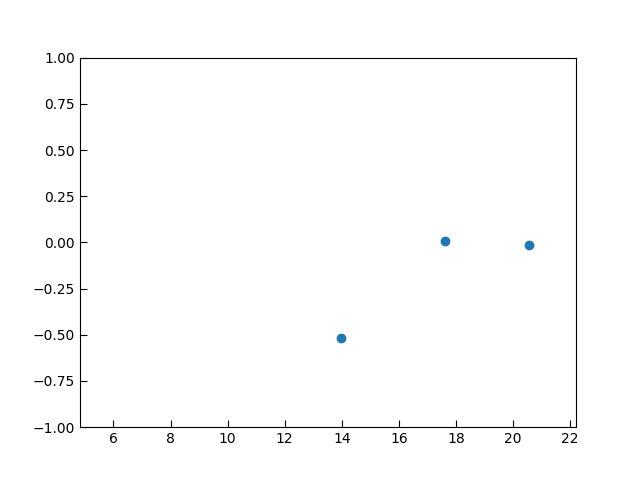

In [37]:
%matplotlib widget
fig,ax = plt.subplots()
ax.scatter(fits_arm2.arm_length, fits_arm2.gamma)
ax.set_ylim(-1,1)

In [38]:
dist_previous = []
for i in range(len(df_tracing_arm1)):
    if i == 0:
        x1 = 0
        y1 = 0
        
        x2 = df_tracing_arm1.iloc[i].x
        y2 = df_tracing_arm1.iloc[i].y
        dist_previous.append(calc_euclidean(x1,y1,x2,y2))
        
    else:
        x1 = df_tracing_arm1.iloc[i-1].x
        y1 = df_tracing_arm1.iloc[i-1].y
        
        x2 = df_tracing_arm1.iloc[i].x
        y2 = df_tracing_arm1.iloc[i].y
        
        dist_previous.append(calc_euclidean(x1,y1,x2,y2))


df_tracing_arm1['dist_previous'] = dist_previous
df_tracing_arm1['arm_length'] = df_tracing_arm1.dist_previous.cumsum()

In [39]:
fits_arm1['arm_length'] = fits_arm1.apply(lambda row: assign_length(row.id_tracing, df_tracing_arm1), axis = 1)

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [40]:
fits_arm1.to_csv(f'DATA/results/Halo_{id_halo}_Arm1_widths_Oct10.csv')

(-1.0, 1.0)

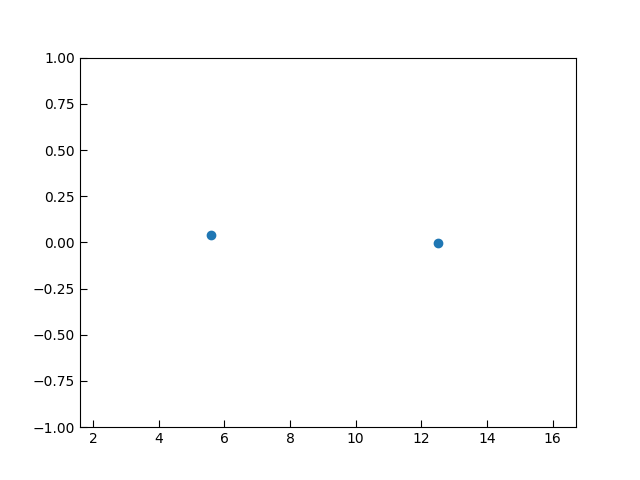

In [41]:
%matplotlib widget
fig,ax = plt.subplots()
ax.scatter(fits_arm1.arm_length, fits_arm1.gamma)
ax.set_ylim(-1,1)

In [42]:
fits_arm1[['amplitude', 'center', 'gamma', 'id_tracing',
       'sigma', 'stderr_amplitude', 'stderr_center', 'arm', 'r_tracing', 'w1', 'w2', 'arm_length']]

,amplitude,center,gamma,id_tracing,sigma,stderr_amplitude,stderr_center,arm,r_tracing,w1,w2,arm_length
0,0.000068,3.065634,-7.053630,0.0,1.749561,0.000008,0.051517,1,2.290399,1.624082,0.545255,2.290399
1,0.000055,3.024764,-16.454760,1.0,1.511794,0.000010,0.029237,1,2.625003,1.552266,0.251277,2.918627
2,0.000052,3.075053,-19.590814,2.0,1.404767,0.000006,0.020546,1,2.704012,1.466337,0.203949,3.746950
3,0.000041,2.968287,-14.223399,3.0,1.155108,0.000004,0.021170,1,2.665744,1.167712,0.215285,4.673043
4,0.000055,2.564958,0.041090,4.0,0.840902,0.000035,1371.885708,1,2.554222,0.989551,0.989560,5.582597
5,0.000041,3.118374,-4.914124,5.0,0.948887,0.000005,0.115127,1,2.778492,0.842588,0.378973,6.660207
6,0.000041,3.118374,-4.914124,5.0,0.948887,0.000005,0.115127,1,2.778492,0.842588,0.378973,6.660207
7,0.000058,3.123517,-7.757767,6.0,1.317065,0.000004,0.046908,1,2.776032,1.238109,0.383344,7.541794
8,0.000058,1.786908,4.715689,7.0,1.500044,0.000008,0.066392,1,2.683426,0.615007,1.326787,8.417335
9,0.000067,1.830593,1.928790,8.0,1.394173,0.000007,0.243776,1,2.842310,0.977888,1.224569,9.027171


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/daniel/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-43-bc0a71f77a6b>", line 2, in <module>
    ax.plot(arm1.x_tracing, arm1.y_tracing)
NameError: name 'arm1' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/daniel/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 1863, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/daniel/anaconda3/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1095, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/home/daniel

NameError: name 'arm1' is not defined

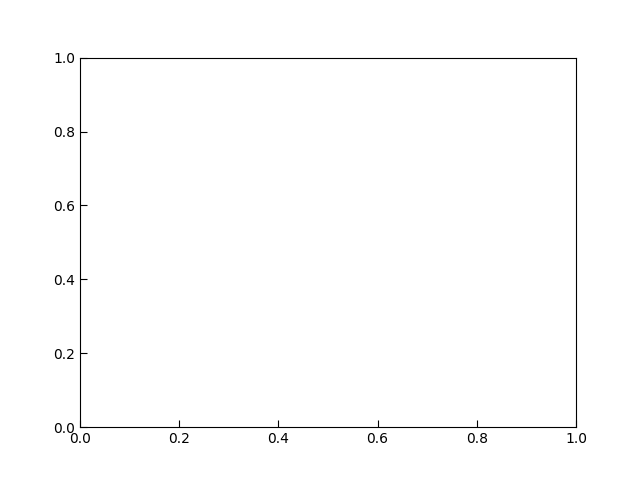

In [43]:
fig, ax = plt.subplots()
ax.plot(arm1.x_tracing, arm1.y_tracing)
ax.plot(arm2.x_tracing, arm2.y_tracing)
ax.set_xlim(-20,20)
ax.set_ylim(-20,20)
ax.set_aspect('equal')

In [44]:
#df_fits.head
#print(df_fits["amplitude"], df_fits["center"], df_fits["sigma"],  df_fits["gamma"], df_fits["x_tracing"], df_fits["y_tracing"], df_fits["x_max"], df_fits["y_max"], df_fits["w1"], df_fits["w2"], df_fits["arm"], df_fits["fractured"])
#print(df_fits["w1"], df_fits["w2"])
#df_fits.to_csv('Arm_width_rho.csv')

In [ ]:
df_print = pd.DataFrame(zip(df_fits.amplitude, df_fits.center, df_fits.sigma, df_fits.gamma, df_fits.x_tracing, df_fits.y_tracing, df_fits.x_max, df_fits.y_max, df_fits.w1, df_fits.w2, df_fits.arm, df_fits.fractured, df_fits.id_tracing))


In [ ]:
df_print.to_csv('Arm2_widths_rho_adicionales_Ago4.csv')

In [ ]:
def find_widths_of_skewed_gaussian_dani(params, dx=0.001):
    # Evaluar el modelo ajustado
    fitted_model = eval_fitted_model_with_given_params(params, dx=dx)
    x_eval = fitted_model['x_eval']
    y_eval = fitted_model['y_eval']

    # Verificar que x_eval y y_eval no estén vacíos
    if len(x_eval) == 0 or len(y_eval) == 0:
        print(f"Advertencia: 'x_eval' o 'y_eval' están vacíos para params id: {params.get('id_tracing', 'desconocido')}")
        return {'x_max': np.nan, 'y_max': np.nan, 'w1': np.nan, 'w2': np.nan}

    # Continúa si no están vacíos
    x_max, y_max = find_maximum(x_eval, y_eval)

    xs_line = np.arange(np.min(x_eval), np.max(x_eval), 0.01)
    ys_line = np.full(len(xs_line), 0.5 * y_max)

    first_line = LineString(np.column_stack((x_eval, y_eval)))
    second_line = LineString(np.column_stack((xs_line, ys_line)))
    intersection = first_line.intersection(second_line)

    points_intercept = []
    if isinstance(intersection, MultiPoint):
        points_intercept = list(intersection)
    elif not intersection.is_empty:
        points_intercept = [intersection]

    points_intercept = [[point.x, point.y] for point in points_intercept]

    if len(points_intercept) >= 2:
        w1 = x_max - points_intercept[1][0]
        w2 = points_intercept[0][0] - x_max
    else:
        w1, w2 = np.nan, np.nan  # Si no hay suficientes intersecciones

    return {'x_max': x_max, 'y_max': y_max, 'w1': w1, 'w2': w2}



df_fits = pd.concat(dfs, axis = 0).reset_index(drop=True)
df_fits['r_tracing'] = np.sqrt(df_fits['x_tracing']**2 + df_fits['y_tracing']**2)
df_fits['width_info'] = df_fits.apply(lambda row: find_widths_of_skewed_gaussian_dani(row), axis = 1)
df_fits['x_max'] = df_fits.apply(lambda row: row.width_info['x_max'], axis = 1)
df_fits['y_max'] = df_fits.apply(lambda row: row.width_info['y_max'], axis = 1)
df_fits['w1'] = df_fits.apply(lambda row: row.width_info['w1'], axis = 1)
df_fits['w2'] = df_fits.apply(lambda row: row.width_info['w2'], axis = 1)